In [266]:
import pandas as pd
import numpy as np
import wget

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
wget.download('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

100% [..........................................................................] 1423529 / 1423529

'housing.csv'

In [267]:
df = pd.read_csv('housing.csv')

In [271]:
df_copy = df.copy()

In [272]:
df_copy.shape

(20640, 10)

In [273]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Data Preparation

In [274]:
# Fill missing values with 0
df_copy.fillna(0, inplace=True)

In [275]:
# Feature Engineering
df_copy['rooms_per_household'] = df['total_rooms']/df['households']

In [276]:
# Feature Engineering
df_copy['bedrooms_per_room'] = df['total_bedrooms']/df['total_rooms']

In [277]:
# Feature Engineering
df_copy['population_per_household'] = df['population']/df['households']

## Question 1
What is the most frequent observation (mode) for the column `ocean_proximity`?

In [280]:
df_copy['ocean_proximity'].mode()[0]

'<1H OCEAN'

## Question 2
#### Correlation Matrix for numerical variables

In [281]:
numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms','total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room','population_per_household']

categorical = ['ocean_proximity']

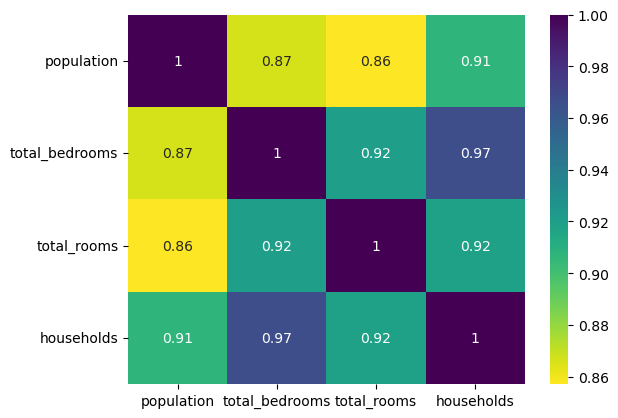

In [288]:
imp_cols = ['population', 'total_bedrooms', 'total_rooms', 'households']
sns.heatmap(df_copy[imp_cols].corr(), annot=True, cmap='viridis_r');

#### Binarize median_house_value

In [290]:
avg = df_copy['median_house_value'].mean()
df_copy['above_average'] = (df_copy['median_house_value'] > avg).astype('int')
df_copy.drop(axis=1, columns='median_house_value', inplace=True)

In [291]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20640 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   ocean_proximity           20640 non-null  object 
 9   rooms_per_household       20640 non-null  float64
 10  bedrooms_per_room         20640 non-null  float64
 11  population_per_household  20640 non-null  float64
 12  above_average             20640 non-null  int32  
dtypes: float64(11), int32(1), object(1)
memory usage: 2.0+ MB


#### Split dataset into train - validate - test

In [93]:
from sklearn.model_selection import train_test_split

In [298]:
def split_dataset_process(df, target):
    df = df.copy()
    
    df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)
    ds = [df_train, df_val, df_test, df_train_full]
    for s in ds:
        s.reset_index(drop=True, inplace=True)
    
    # Get y values
    y_train_full = df_train_full[target].values
    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values
    
    # Delete target variable from X set
    del df_train[target]
    del df_val[target]
    del df_test[target]
    
    return [df_train_full, df_train, df_test, df_val, y_train_full, y_train, y_val, y_test]

In [301]:
df_train_full, df_train, df_test, df_val, y_train_full, y_train, y_val, y_test = split_dataset_process(df_copy, 'above_average')

In [307]:
len(df_train), len(df_test), len(df_val)

(12384, 4128, 4128)

## Question 3
## Mutual Information

In [308]:
from sklearn.metrics import mutual_info_score
from IPython.display import display

In [310]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.above_average)

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')


display(df_mi)

,MI
ocean_proximity,0.101922


In [311]:
round(df_mi['MI'].values[0], 2)

0.1

## Question 4
## Logistic Regression

In [312]:
from sklearn.feature_extraction import DictVectorizer

In [315]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [316]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

In [317]:
dv.get_feature_names_out()

array(['bedrooms_per_room', 'households', 'housing_median_age',
       'latitude', 'longitude', 'median_income',
       'ocean_proximity=<1H OCEAN', 'ocean_proximity=INLAND',
       'ocean_proximity=ISLAND', 'ocean_proximity=NEAR BAY',
       'ocean_proximity=NEAR OCEAN', 'population',
       'population_per_household', 'rooms_per_household',
       'total_bedrooms', 'total_rooms'], dtype=object)

In [319]:
from sklearn.linear_model import LogisticRegression

In [320]:
model=LogisticRegression(solver="liblinear",C=1.0,max_iter=1000,random_state=42)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [321]:
model.coef_

array([[ 3.41281905e-01,  3.98762376e-03,  3.60259800e-02,
         1.30140624e-01,  9.15912335e-02,  1.21623656e+00,
         4.74922642e-01, -1.76232572e+00,  3.54534386e-02,
         2.29334213e-01,  8.90880953e-01, -1.63818534e-03,
         1.04225229e-02, -9.88403287e-03,  1.83522544e-03,
        -1.42062788e-04]])

In [322]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [323]:
model.predict_proba(X_val)

array([[0.92276364, 0.07723636],
       [0.81018183, 0.18981817],
       [0.04759572, 0.95240428],
       ...,
       [0.03738127, 0.96261873],
       [0.14818724, 0.85181276],
       [0.53810721, 0.46189279]])

In [324]:
y_pred = model.predict_proba(X_val)[:, 1]

In [325]:
house_value = y_pred > 0.5

In [329]:
original_accuracy = round((y_val == house_value).mean(), 2)
original_accuracy

0.84

## Question 5
#### Feature Elimination Technique

In [338]:
features = numerical + categorical

In [341]:
from sklearn.linear_model import LogisticRegression

for col in features:
    ss = features.copy()
    ss.remove(col)
    train_dict = df_train[ss].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    
    model=LogisticRegression(solver="liblinear",C=1.0,max_iter=1000,random_state=42)
    model.fit(X_train, y_train)
    
    val_dict = df_val[ss].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    y_pred = model.predict(X_val)
    
    accuracy = (y_val == y_pred).mean()
    
    print(col, original_accuracy - accuracy)

longitude 0.007151162790697607
latitude 0.00642441860465115
housing_median_age 0.010058139534883659
total_rooms 0.003759689922480547
total_bedrooms 0.0032751937984495383
population 0.013691860465116279
households 0.00618217054263559
median_income 0.0548740310077519
rooms_per_household 0.004970930232558124
bedrooms_per_room 0.003517441860465098
population_per_household 0.003517441860465098
ocean_proximity 0.019505813953488382


## Question 6

In [342]:
main_df = df.copy()
main_df.fillna(0, inplace=True)

## Data Preparation

In [343]:
# Fill missing values with 0
df.fillna(0, inplace=True)

In [344]:
# Feature Engineering
main_df['rooms_per_household'] = main_df['total_rooms']/main_df['households']

In [345]:
# Feature Engineering
main_df['bedrooms_per_room'] = main_df['total_bedrooms']/main_df['total_rooms']

In [346]:
# Feature Engineering
main_df['population_per_household'] = main_df['population']/main_df['households']

In [347]:
main_df['median_house_value'] = np.log1p(main_df['median_house_value'])

#### Split dataset into train - validate - test

In [348]:
df_train_full, df_train, df_test, df_val, y_train_full, y_train, y_val, y_test = split_dataset_process(main_df, 'median_house_value')

In [349]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [350]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

In [352]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [263]:
from sklearn.linear_model import Ridge

In [362]:
for i in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=i, solver="sag", random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    
    score = rmse(y_val, y_pred)

    print(i,':', round(score, 3))

    

0 : 0.524
0.01 : 0.524
0.1 : 0.524
1 : 0.524
10 : 0.524


In [246]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)